### **Employee Salary Prediction**
Complete data preprocessing and model comparison using ML algorithms

## **Import Required Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


## **Load the Dataset**

In [3]:
data = pd.read_csv("/content/drive/MyDrive/adult 3.csv")

data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## **Drop Unnecessary Column**

In [4]:
data.drop(['fnlwgt'], axis=1, inplace=True)

## **Handle Missing Values**

In [5]:
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

## **Visualize Missing Data**

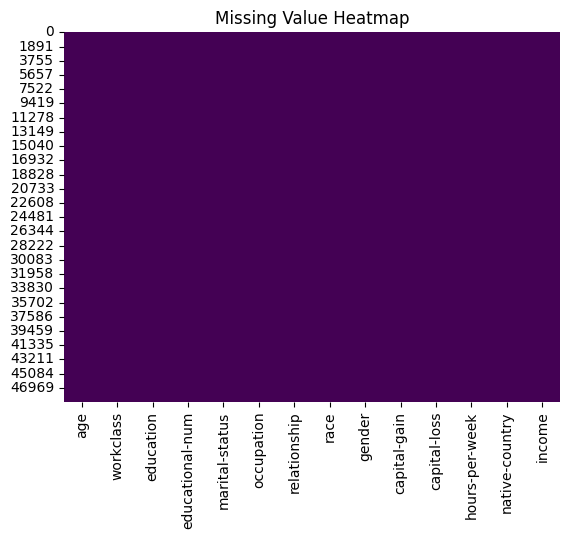

In [6]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

## **Remove Rare/Invalid Values**

In [7]:
data = data[~data['workclass'].isin(['Without-pay', 'Never-worked'])]

low_edu = ['10th', '11th', '7th-8th', '9th', '5th-6th', '1st-4th', 'Preschool', '12th']
data = data[~data['education'].isin(low_edu)]

rare_jobs = ['Armed-Forces', 'Priv-house-serv']
data = data[~data['occupation'].isin(rare_jobs)]

data

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
7,63,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## **Group Rare Countries**

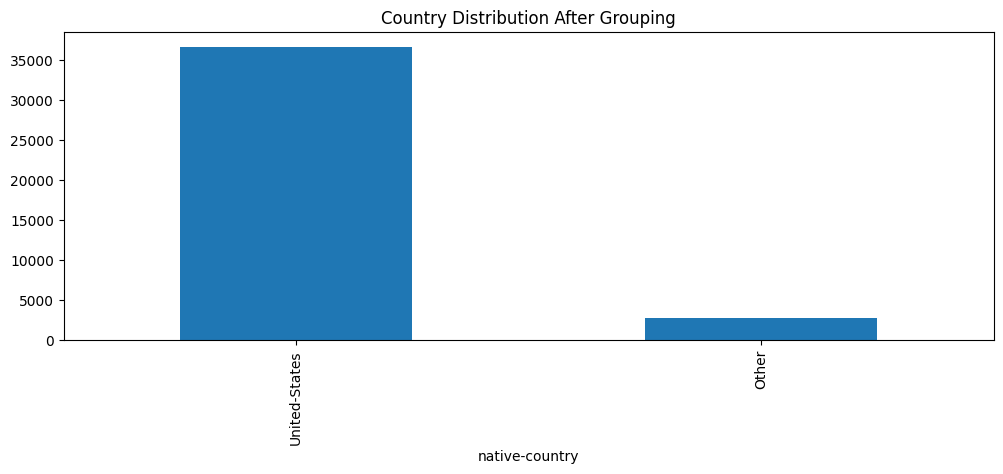

In [8]:
country_counts = data['native-country'].value_counts()
rare_countries = country_counts[country_counts < 500].index

data['native-country'] = data['native-country'].apply(lambda x: 'Other' if x in rare_countries else x)

country_counts_updated = data['native-country'].value_counts()
country_counts_updated.plot(kind='bar', figsize=(12, 4), title="Country Distribution After Grouping")
plt.show()

## **Remove Outliers (IQR Method)**

In [9]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

data = remove_outliers_iqr(data, 'age')
data = remove_outliers_iqr(data, 'hours-per-week')
data = data[(data['educational-num'] <= 16) & (data['educational-num'] >= 5)]


## **Visualize Outliers**

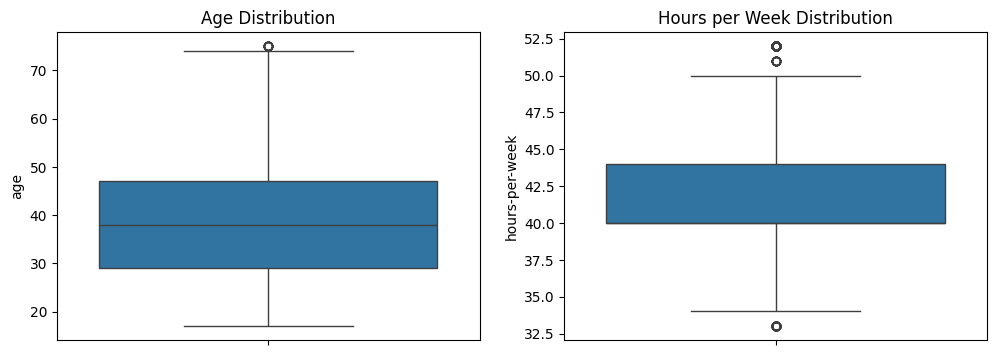

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data['age'], ax=axes[0]).set_title("Age Distribution")
sns.boxplot(data['hours-per-week'], ax=axes[1]).set_title("Hours per Week Distribution")
plt.show()

## **Drop Redundant Education Column**

In [11]:
data.drop(columns=['education'], inplace=True)

## **Encode Categorical Variables**

In [12]:
categorical_cols = data.select_dtypes(include='object').columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print("Encoded columns:", categorical_cols)


Encoded columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


## **Feature and Target Separation**

In [13]:
X = data.drop('income', axis=1)
y = data['income']

## **Standardize the Data**

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Train-Test Split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **Train and Evaluate ML Models**

In [16]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "GradientBoosting": GradientBoostingClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(),
    "ExtraTrees": ExtraTreesClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

LogisticRegression: 0.7952
RandomForest: 0.8201
KNN: 0.8020
SVM: 0.8209
GradientBoosting: 0.8398
DecisionTree: 0.7844
NaiveBayes: 0.7731
ExtraTrees: 0.8063
XGBoost: 0.8456


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:41:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## **Visualize Model Accuracy**

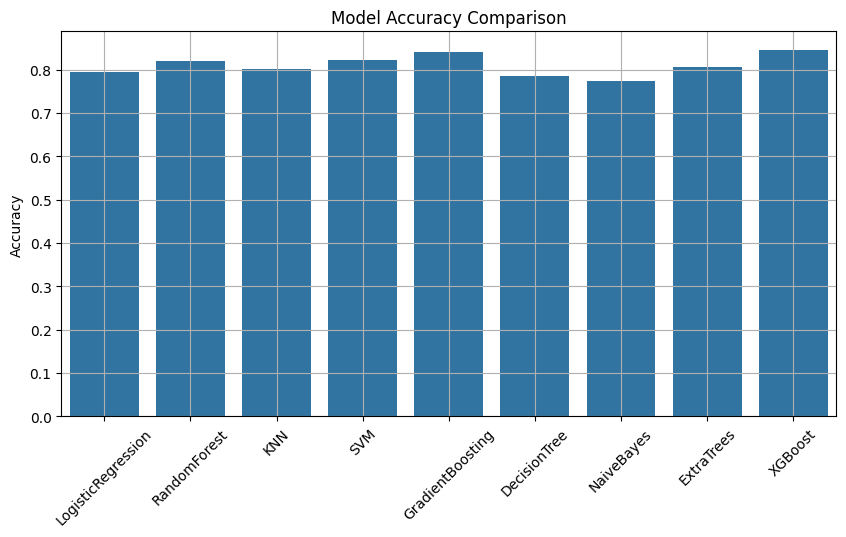

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## **Save the Best Model**

In [18]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\n Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


 Best model: XGBoost with accuracy 0.8456


['label_encoders.pkl']

## **Streamlit App Code**

In [19]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")

expected_features = ['age', 'workclass', 'educational-num', 'marital-status',
                     'occupation', 'relationship', 'race', 'gender',
                     'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

st.set_page_config(page_title="Employee Salary Predictor", layout="wide")

st.markdown("<h1 style='text-align:center;'>💼 Employee Salary Predictor</h1>", unsafe_allow_html=True)
st.markdown("<h4 style='text-align:center;'>Enter employee details to predict income class</h4>", unsafe_allow_html=True)

col1, col2 = st.columns(2)

with col1:
    age = st.slider("Age", 18, 75, 30)
    workclass = st.selectbox("Workclass", label_encoders['workclass'].classes_)
    education_num = st.slider("Educational Number", 1, 16, 10)
    marital_status = st.selectbox("Marital Status", label_encoders['marital-status'].classes_)
    occupation = st.selectbox("Occupation", label_encoders['occupation'].classes_)
    relationship = st.selectbox("Relationship", label_encoders['relationship'].classes_)

with col2:
    race = st.selectbox("Race", label_encoders['race'].classes_)
    gender = st.selectbox("Gender", label_encoders['gender'].classes_)
    capital_gain = st.number_input("Capital Gain", 0, 99999, 0)
    capital_loss = st.number_input("Capital Loss", 0, 4356, 0)
    hours_per_week = st.slider("Hours per Week", 1, 50, 40)
    native_country = st.selectbox("Native Country", label_encoders['native-country'].classes_)

input_dict = {
    'age': [age],
    'workclass': [workclass],
    'educational-num': [education_num],
    'marital-status': [marital_status],
    'occupation': [occupation],
    'relationship': [relationship],
    'race': [race],
    'gender': [gender],
    'capital-gain': [capital_gain],
    'capital-loss': [capital_loss],
    'hours-per-week': [hours_per_week],
    'native-country': [native_country]
}

input_df = pd.DataFrame(input_dict)

for col in input_df.columns:
    if input_df[col].dtype == 'object':
        input_df[col] = label_encoders[col].transform(input_df[col])

input_df = input_df[expected_features]
input_scaled = scaler.transform(input_df)

if st.button("🔍 Predict Salary Class"):
    prediction = model.predict(input_scaled)[0]
    confidence = model.predict_proba(input_scaled)[0][prediction] if hasattr(model, 'predict_proba') else 1.0
    confidence_percent = float(confidence) * 100

    st.markdown("---")
    if prediction == 1:
        st.markdown("""
            <div style='background-color:#d1e7dd; padding:20px; border-radius:10px'>
                <h3 style='color:#0f5132;'>💼 <u>Prediction Result</u></h3>
                <p style='font-size:20px; color:#FF0000;'>✅ <strong>Employee is likely to earn more than 50K/year</strong></p>
            </div>
        """, unsafe_allow_html=True)
    else:
        st.markdown("""
            <div style='background-color:#fff3cd; padding:20px; border-radius:10px'>
                <h3 style='color:#664d03;'>📉 <u>Prediction Result</u></h3>
                <p style='font-size:20px; color:#FF0000;'>⚠️ <strong>Employee is likely to earn less than or equal to 50K/year</strong></p>
            </div>
        """, unsafe_allow_html=True)



    st.markdown(f"### Confidence: `{confidence_percent:.2f}%`")
    st.progress(min(int(confidence_percent), 100))

    with st.expander("🔍 View Input Data"):
        st.dataframe(input_df)


Writing app.py


## **host Using Streamlit**

In [23]:
!pip install -q streamlit pyngrok

from pyngrok import ngrok
# Terminate all existing tunnels
ngrok.kill()

NGROK_AUTH_TOKEN = "2ezM4l0FUFAjpdDZrh88GQsADEK_mKS25inaxmC6fDLti65c"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

!nohup streamlit run app.py --server.port 8501 &
public_url = ngrok.connect(addr="8501", proto="http")

print(" Your app is live at:", public_url)

ERROR: Operation cancelled by user
nohup: appending output to 'nohup.out'
 Your app is live at: NgrokTunnel: "https://c7224f9f6bcf.ngrok-free.app" -> "http://localhost:8501"
